# Flight Price Prediction
---

In [ ]:
import tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor


sns.set()

## Importing dataset

1. Since data is in form of excel file we have to use pandas read_excel to load the data
2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3. Check whether any null values are there or not. if it is present then following can be done,
    1. Imputing data using Imputation method in sklearn
    2. Filling NaN values with mean, median and mode using fillna() method
4. Describe data --> which can give statistical analysis

In [2]:
import sklearn
print(sklearn.__version__)


1.3.1


In [3]:
train = pd.read_csv(r"C:\Users\Nasem\Desktop\train.csv", index_col='id')
test = pd.read_csv(r"C:\Users\Nasem\Desktop\test.csv", index_col='id')


target = 'Strength'
original_features = list(test.columns)

print(f"Length of train: {len(train)}")
print(f"Length of test:  {len(test)}")

print()

temp1 = train.isna().sum().sum()
temp2 = test.isna().sum().sum()
if temp1 == 0 and temp2 == 0:
    print('There are no null values in train and test.')
else:
    print(f'There are {temp1} null values in train')
    print(f'There are {temp2} null values in train')
print()

traindup = train[test.columns].duplicated().sum()
print(f"Duplicates in train: {traindup:4}")
print(f"Duplicates in test:  {test.duplicated().sum():4}")
print(f"Duplicates in train and test together: {pd.concat([train, test], axis=0)[test.columns].duplicated().sum()}")
print()

print('Sample lines from train:')
train.tail(3)

Length of train: 5407
Length of test:  3605

There are no null values in train and test.

Duplicates in train: 2401
Duplicates in test:  1351
Duplicates in train and test together: 4403

Sample lines from train:


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61
5406,190.7,0.0,125.2,166.6,7.9,1079.0,770.1,56,63.14


In [4]:
train = train.drop(columns=[ 'CoarseAggregateComponent','SuperplasticizerComponent' ])


In [5]:
test = test.drop(columns=['CoarseAggregateComponent','SuperplasticizerComponent' ])

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
train.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,
0,525.0,0.0,0.0,186.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,795.3,28,36.96
3,304.0,76.0,0.0,228.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,781.2,90,74.19


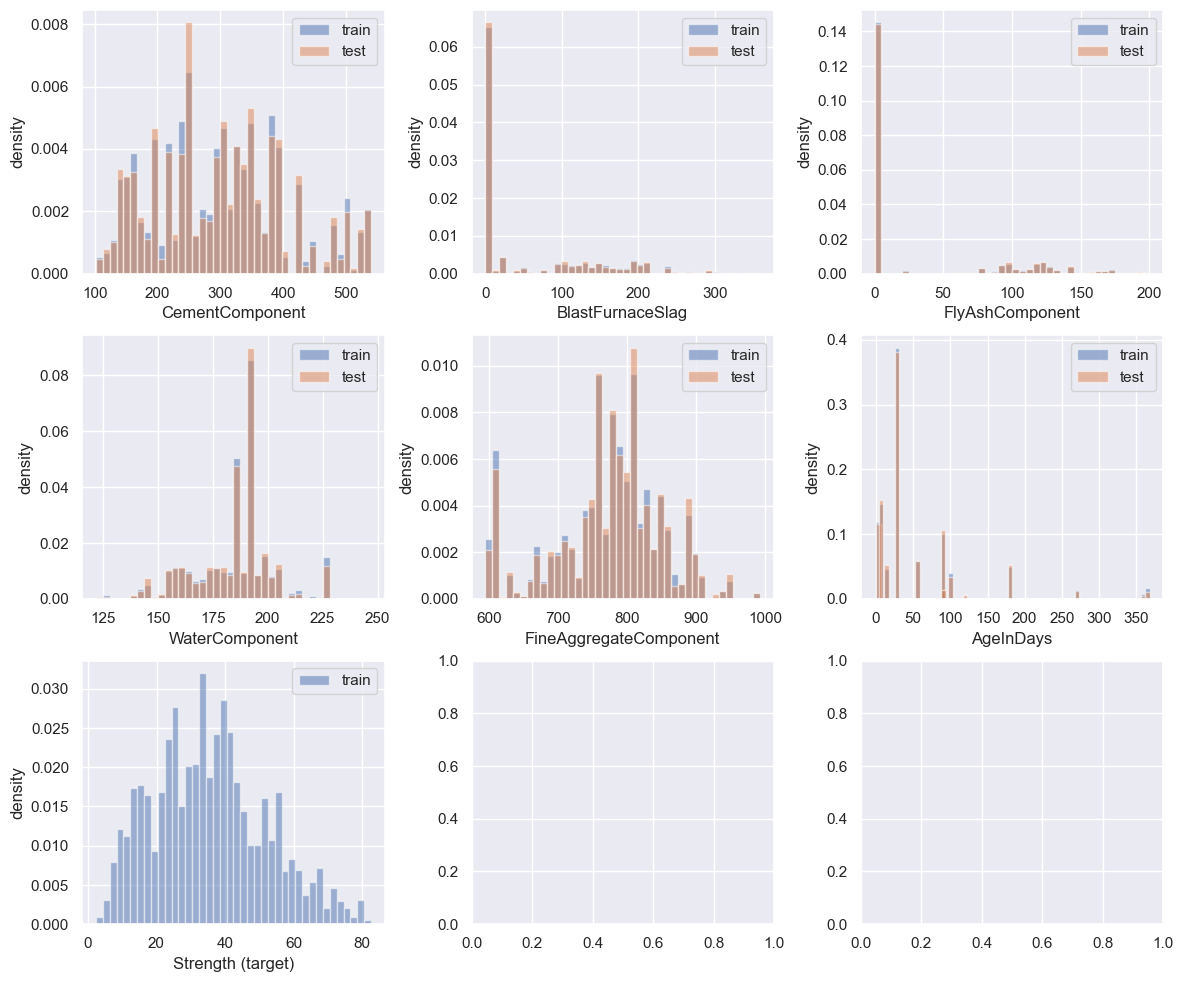

In [8]:
def analyze(train, test, col, ax):
    """Plot a histogram for column col into axes ax"""
    bins = 40
    column = train[col]
    if col in test.columns:
        both = np.hstack([column.values, test[col].values])
    else:
        both = column
    uni = np.unique(column)
    unival = len(uni)
    if unival < bins:
        vc_tr = column.value_counts().sort_index() / len(train)
        if col in test.columns:
            vc_te = test[col].value_counts().sort_index() / len(test)
            ax.bar(vc_tr.index, vc_tr, width=6, label='train', alpha=0.5)
            ax.bar(vc_te.index, vc_te, width=6, label='test', alpha=0.5)
        else:
            ax.bar(vc_tr.index, vc_tr, label='train', alpha=0.5)
        if unival <= 12:
            ax.set_xticks(vc_tr.index)
        else:
            ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
        ax.set_xlabel(col + (' (target)' if col == target else ''))
        ax.set_ylabel('density')
        ax.legend()
    else:
        hist_bins = np.linspace(both.min(), both.max(), bins+1)
        ax.hist(column, bins=hist_bins, density=True, label='train', alpha=0.5)
        if col in test.columns:
            ax.hist(test[col], bins=hist_bins, density=True, label='test', alpha=0.5)
        ax.set_xlabel(col + (' (target)' if col == target else ''))
        ax.set_ylabel('density')
        ax.legend()
    
_, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.ravel()
for col, ax in zip(train.columns, axs):
    analyze(train, test, col, ax)
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

In [9]:
print('Value counts for AgeInDays')
pd.concat([train, test], axis=0).AgeInDays.value_counts().sort_index()

Value counts for AgeInDays


AgeInDays
1         8
3      1053
7      1345
11        1
14      435
28     3474
49        1
56      526
90      922
91      124
100     334
120      36
180     454
270     116
360      52
365     131
Name: count, dtype: int64

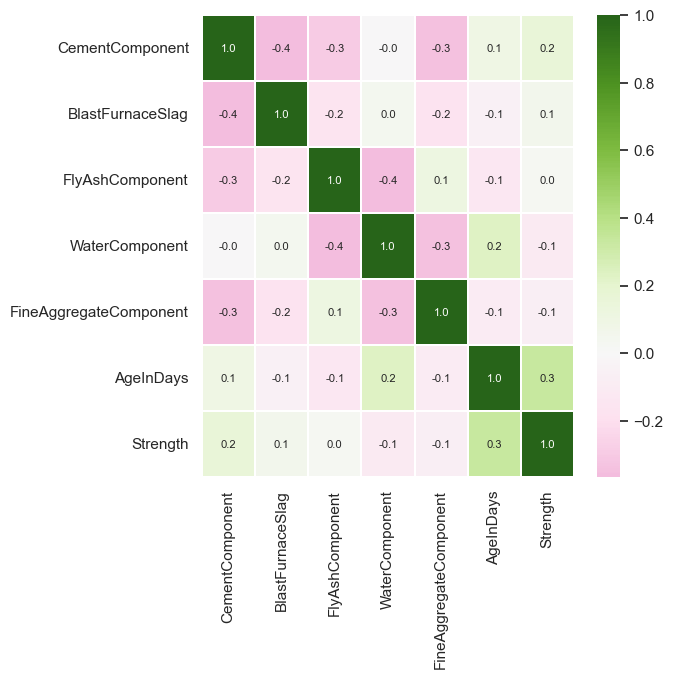

In [10]:
corr = train.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, linewidth=0.1, fmt='.1f', 
            annot=True, annot_kws={'size': 8}, 
            cmap='PiYG', center=0)
plt.show()

In [11]:
original_features = list(test.columns)
train_feature=list(train.columns)

In [12]:
original_features

['CementComponent',
 'BlastFurnaceSlag',
 'FlyAshComponent',
 'WaterComponent',
 'FineAggregateComponent',
 'AgeInDays']

In [13]:
train_feature

['CementComponent',
 'BlastFurnaceSlag',
 'FlyAshComponent',
 'WaterComponent',
 'FineAggregateComponent',
 'AgeInDays',
 'Strength']

In [14]:
result_list = []

In [15]:
%%time

def score_model(model, features_used, label=None):
    """Cross-validate a model with feature selection"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold()
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
#         X_tr = pd.concat([X_tr, original[features_used]], axis=0)
#         y_tr = pd.concat([y_tr, original[target]], axis=0)
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessRegressor:
            print('Kernel:', model.steps[-1][1].kernel_)
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))

score_model(model=make_pipeline(StandardScaler(), Ridge(70)),
            features_used=original_features)

Fold 0: trmse = 14.690   rmse = 14.812
Fold 1: trmse = 14.715   rmse = 14.729
Fold 2: trmse = 14.826   rmse = 14.251
Fold 3: trmse = 14.842   rmse = 14.208
Fold 4: trmse = 14.464   rmse = 15.686
Average rmse: 14.737
CPU times: total: 0 ns
Wall time: 41.8 ms


In [16]:

    
score_model(model=make_pipeline(StandardScaler(), Ridge(70)),
            features_used=test.columns)

Fold 0: trmse = 14.690   rmse = 14.812
Fold 1: trmse = 14.715   rmse = 14.729
Fold 2: trmse = 14.826   rmse = 14.251
Fold 3: trmse = 14.842   rmse = 14.208
Fold 4: trmse = 14.464   rmse = 15.686
Average rmse: 14.737


In [17]:
score_model(model=RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1),
            features_used=original_features,
            label='Random Forest')

Fold 0: trmse = 11.650   rmse = 11.898
Fold 1: trmse = 11.574   rmse = 12.133
Fold 2: trmse = 11.634   rmse = 11.817
Fold 3: trmse = 11.636   rmse = 11.927
Fold 4: trmse = 11.400   rmse = 12.948
Average rmse: 12.145


In [18]:
%time
modeli = RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)
modeli.fit(train[original_features], train[target])

'''features_for_pdp = original_features
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
plt.suptitle('Partial Dependence', y=1.0)
PartialDependenceDisplay.from_estimator(model, train[original_features],
                                        features_for_pdp,
                                        pd_line_kw={"color": "red"},
                                        ice_lines_kw={"color": "blue"},
                                        kind='both',
                                        ax=axs.ravel()[:len(features_for_pdp)])
plt.tight_layout(h_pad=0.3, w_pad=0.5)
plt.show()'''

CPU times: total: 0 ns
Wall time: 0 ns


'features_for_pdp = original_features\nfig, axs = plt.subplots(2, 4, figsize=(12, 5))\nplt.suptitle(\'Partial Dependence\', y=1.0)\nPartialDependenceDisplay.from_estimator(model, train[original_features],\n                                        features_for_pdp,\n                                        pd_line_kw={"color": "red"},\n                                        ice_lines_kw={"color": "blue"},\n                                        kind=\'both\',\n                                        ax=axs.ravel()[:len(features_for_pdp)])\nplt.tight_layout(h_pad=0.3, w_pad=0.5)\nplt.show()'

In [19]:
%%time
modeli.fit(train[test.columns], train[target])
y_pred = modeli.predict(test[test.columns])
pd.Series(y_pred, index=test.index, name=target).to_csv(f"submission.csv")
y_pred.round(1)

CPU times: total: 3.98 s
Wall time: 8.89 s


array([49.6, 19.4, 34. , ..., 39.1, 28.1, 23.4])

---

## EDA

In [20]:
import pickle
# open a file, where you ant to store the data
file = open('modelforconcretstrength.pkl', 'wb')

# dump information to that file
pickle.dump(modeli, file)

In [21]:
model = open('modelforconcretstrength.pkl','rb')
forest = pickle.load(model)

---